In [1]:
using Parameters
using DifferentialEquations
using MLStyle
using RCall
R"require('tidyverse')"

System has not been booted with systemd as init system (PID 1). Can't operate.
Failed to create bus connection: Host is down
┌ Warning: RCall.jl: Loading required package: tidyverse
│ Warning in system("timedatectl", intern = TRUE) :
│   running command 'timedatectl' had status 1
│ ── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──
│ ✔ ggplot2 3.3.5     ✔ purrr   0.3.4
│ ✔ tibble  3.1.6     ✔ dplyr   1.0.8
│ ✔ tidyr   1.2.0     ✔ stringr 1.4.0
│ ✔ readr   2.1.2     ✔ forcats 0.5.1
│ ── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
│ ✖ dplyr::filter() masks stats::filter()
│ ✖ dplyr::lag()    masks stats::lag()
└ @ RCall /home/jovyan/.julia/packages/RCall/6kphM/src/io.jl:172


RObject{LglSxp}
[1] TRUE


$$
m\ddot x + c\dot x + k x = D\dot e + P e + I \int_0^t e du\\
e(t) = r(t) - x(t)
$$

In [127]:
module T

using Parameters
using MLStyle
using DifferentialEquations

@with_kw mutable struct Params
    m = 1.0
    c = 8.4
    k = 40.0
    P = 1.0
    I = 1.0
    D = 1.0
    ṙ = 0.0
    g = 9.8
end

dynamics = (du,u,p,t) -> begin
    @unpack_Params p
    ∫r,r,∫x,x,ẋ = u
    d∫r = r
    dr = ṙ
    d∫x = x
    dx = ẋ
    dẋ = (D*(ṙ-ẋ) + P*(r-x) + I*(∫r-∫x) - c*ẋ - k*x)/m
    du .= d∫r,dr,d∫x,dx,dẋ
end

condition = (out, u,t,int) -> begin
    out[1] = t - 5
    out[2] = t - 5.1
end

affect! = (int,idx) -> begin
    @match idx begin
        1 => begin int.p.ṙ += 1/0.1 end
        2 => begin int.p.ṙ -= 1/0.1 end
    end
end

callback = VectorContinuousCallback(condition, affect!, 2)

end

Main.T

In [221]:
Pkg.build("Interact")

    Building WebIO ───────→ `~/.julia/scratchspaces/44cfe95a-1eb2-52ea-b672-e2afdf69b78f/c9529be473e97fa0b3b2642cdafcd0896b4c9494/build.log`
    Building Knockout ────→ `~/.julia/scratchspaces/44cfe95a-1eb2-52ea-b672-e2afdf69b78f/deb74017e1061d76050ff68d219217413be4ef59/build.log`
    Building InteractBase → `~/.julia/scratchspaces/44cfe95a-1eb2-52ea-b672-e2afdf69b78f/3ace4760fab1c9700ec9c68ab0e36e0856f05556/build.log`
    Building Interact ────→ `~/.julia/scratchspaces/44cfe95a-1eb2-52ea-b672-e2afdf69b78f/311f9130aeb50ac93a12dd076fa02c9a430be525/build.log`


In [ ]:
using Conda
Conda.pip_interop(true)
Conda.pip("install", "webio_jupyter_extension")

In [2]:
using Interact
ui = button()
display(ui)

(div { className="field interact-widget" }
    (button { attributes=Dict{Any, Any}("data-bind" => "click: function (){this.clicks(this.clicks()+1)}, css: {'is-loading' : loading}") className="is-medium button is-primary" style=Dict{String, Any}() }
    "Press me!"))

In [4]:
display(ui)

(div { className="field interact-widget" }
    (button { attributes=Dict{Any, Any}("data-bind" => "click: function (){this.clicks(this.clicks()+1)}, css: {'is-loading' : loading}") className="is-medium button is-primary" style=Dict{String, Any}() }
    "Press me!"))

In [211]:
u0 = Float64[0,0,0,0,0]
p0 = T.Params(P=10.0, I=0.0, D=0.0, k = 0.0)
tspan = (0.0, 10.0)
prob = ODEProblem(T.dynamics, u0, tspan, p0)
sol = solve(prob, Tsit5(), callback = T.callback)
;

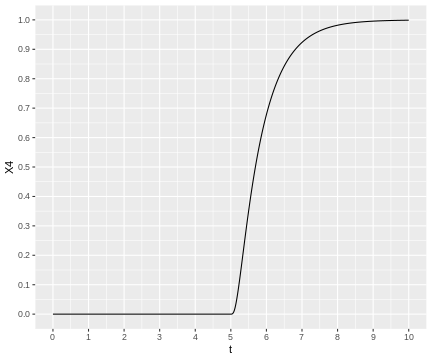

RObject{VecSxp}


In [212]:
t = range(tspan..., length=1024)
R"
data.frame(
    t = $t,
    $(reduce(hcat, sol(t).u)')
) %>%
ggplot() +
    geom_path(aes(t, X4)) +
    scale_x_continuous(breaks = seq(0,10)) +
    scale_y_continuous(breaks = seq(0,1,by=.1))
"

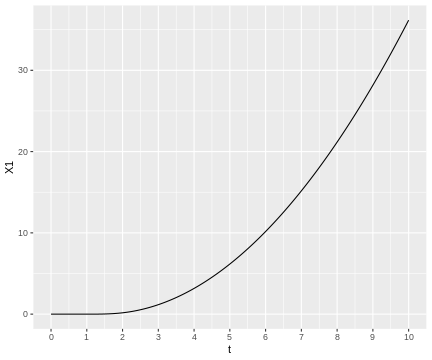

RObject{VecSxp}


In [78]:
t = range(0,10,length=1024)

R"
data.frame(
    t = $t,
    $(reduce(hcat, sol(t).u)')
) %>%
ggplot() +
    geom_path(aes(t,X1)) +
    scale_x_continuous(breaks = 0:10)
"

In [3]:
dynamics = (du,u,p,t) -> begin
    m,c,k,F = p
    du[1] = u[2]
    du[2] = (F - c*u[2] - k*u[1])/m
end

condition = (out,u,t,int) -> begin
    out[1] = u[1]
    out[2] = u[3] * (u[3] - 2)
end

affect! = (int,idx) -> begin     
    @match idx begin
        1 => begin
            int.u[2] *= -.9
        end
        2 => begin
            int.u[4] *= -.9
        end
    end
end

#5 (generic function with 1 method)

In [62]:
T = 10.0

prob = ODEProblem(dynamics, [0.0, 0.0, 0.0], (0.0, T), (1.0, 8.8, 40.0, 10.0))
sol = solve(
    prob,
    Tsit5(),
    # callback = VectorContinuousCallback(condition, affect!, 2)
)
;1

1

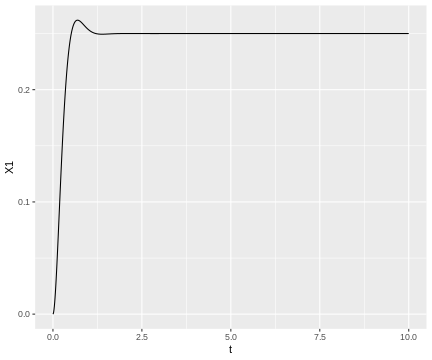

RObject{VecSxp}


In [63]:
t = range(0,T,length=1024)
R"
data.frame(
    t=$t,
    $(reduce(hcat, sol(t).u)')    
) %>%
ggplot() +
    geom_path(aes(t,X1))
"

In [4]:
@enum State STOPPED MOVING

```
@enum EnumName[::BaseType] value1[=x] value2[=y]
```

Create an `Enum{BaseType}` subtype with name `EnumName` and enum member values of `value1` and `value2` with optional assigned values of `x` and `y`, respectively. `EnumName` can be used just like other types and enum member values as regular values, such as

# Examples

```jldoctest fruitenum
julia> @enum Fruit apple=1 orange=2 kiwi=3

julia> f(x::Fruit) = "I'm a Fruit with value: $(Int(x))"
f (generic function with 1 method)

julia> f(apple)
"I'm a Fruit with value: 1"

julia> Fruit(1)
apple::Fruit = 1
```

Values can also be specified inside a `begin` block, e.g.

```julia
@enum EnumName begin
    value1
    value2
end
```

`BaseType`, which defaults to [`Int32`](@ref), must be a primitive subtype of `Integer`. Member values can be converted between the enum type and `BaseType`. `read` and `write` perform these conversions automatically. In case the enum is created with a non-default `BaseType`, `Integer(value1)` will return the integer `value1` with the type `BaseType`.

To list all the instances of an enum use `instances`, e.g.

```jldoctest fruitenum
julia> instances(Fruit)
(apple, orange, kiwi)
```
